In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
matplotlib.style.use('seaborn-pastel')

In [12]:
def convert_to_float(value):
    """
    Transforms argument value to float;
    Replaces the comma in a string variable with a dot and rounds the value to two decimal places;
    
    Parameters
    --------
    value: float
    
    Returns
    --------
    float
    
    """
    value = float(str(value).replace(",", "."))
    value = round(value, 2)
    return value

#######################################################################################################################

## Подготовка данных

In [13]:
# Загрузка датафрейма из CSV файла;
textiles = pd.read_csv('../data/textiles.csv', sep=';')

In [14]:
textiles.columns

Index(['order', 'grave', 'add', 'z', 'internal_storage', 'number', 'warp_size',
       'weft_size', 'type', 'item_no', 'structure', 'condition',
       'weaving_technique', 'warp_material', 'weft_material', 'warp_dyed',
       'weft_dyed', 'twist_warp', 'twist_weft', 'angle_warp', 'angle_weft',
       'even (равномерность — фактор)', 'cover factor', 'selvedge', 'warp_a',
       'warp_b', 'warp_mean', 'weft_a', 'weft_b', 'weft_mean', 'warp_dens',
       'weft_dens'],
      dtype='object')

In [15]:
# Приведение типов колонок датафрейма к значению с плавающей запятой;
textiles['warp_a'] = textiles.warp_a.apply(convert_to_float)
textiles['warp_b'] = textiles.warp_b.apply(convert_to_float)
textiles['weft_a'] = textiles.weft_a.apply(convert_to_float)
textiles['weft_b'] = textiles.weft_b.apply(convert_to_float)
textiles['warp_mean'] = textiles.warp_mean.apply(convert_to_float)
textiles['weft_mean'] = textiles.weft_mean.apply(convert_to_float)
textiles['warp_dens'] = textiles.warp_dens.apply(convert_to_float)
textiles['weft_dens'] = textiles.weft_dens.apply(convert_to_float)

# Вычисление "усредненных" толщин нитей;
textiles['warp_nominal'] = round((textiles['warp_a'] + textiles['warp_b']) / 2, 2)
textiles['weft_nominal'] = round((textiles['weft_a'] + textiles['weft_b']) / 2, 2)

# "коэффициенты" толщин и плотностей;
textiles['thick_coef'] = round(textiles['warp_nominal'] / textiles['weft_nominal'], 2)
textiles['dens_coef'] = round(textiles['warp_dens'] / textiles['weft_dens'], 2)

In [16]:
textiles = textiles[['order', 'internal_storage', 'type', 'warp_nominal', 'weft_nominal', 'warp_dens', 'weft_dens']]

In [18]:
textiles.type.value_counts()

n_band            94
m_band            81
fabric            44
funeral_shroud    27
textile           22
w_band            19
f_strip            7
patch_fabric       3
band               2
sewn_item          2
f_overlay          1
filling            1
Name: type, dtype: int64

In [21]:
textiles.isna().sum()

order               20
internal_storage     0
type                 0
warp_nominal         0
weft_nominal         0
warp_dens            1
weft_dens            1
dtype: int64

In [22]:
len(textiles)

303

## Графики распределение толщин нитей и плотностей ткани до исключения выбросов

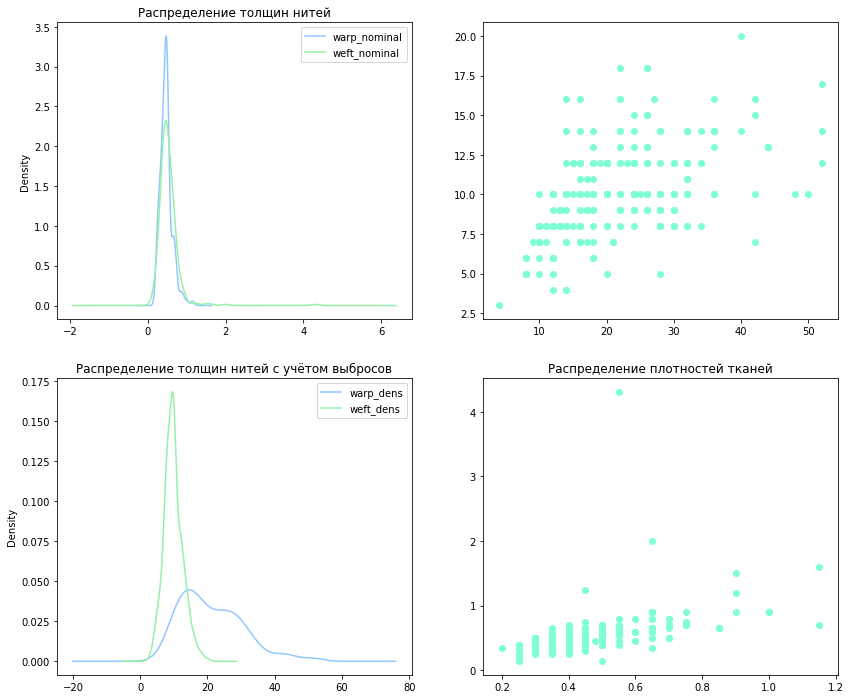

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

ax[0][0].set_title('Распределение толщин нитей')
ax[1][0].set_title('Распределение толщин нитей с учётом выбросов')
ax[1][1].set_title('Распределение плотностей тканей')

textiles.warp_nominal.plot.kde(ax=ax[0][0])
textiles.weft_nominal.plot.kde(ax=ax[0][0])

ax[0][1].scatter(textiles.warp_dens.tolist(), textiles.weft_dens.tolist(), color='aquamarine', label='Плотность по основе')

textiles.warp_dens.plot.kde(ax=ax[1][0])
textiles.weft_dens.plot.kde(ax=ax[1][0])

ax[1][1].scatter(textiles.warp_nominal.tolist(), textiles.weft_nominal.tolist(), color='aquamarine', label='Плотность по утку')

ax[0][0].legend()
ax[1][0].legend()

plt.show()

In [8]:
print(textiles.dens_coef.min())
print(textiles.dens_coef.max())
print(textiles.dens_coef.mean())
print(textiles.dens_coef.quantile(0.25))
print(textiles.dens_coef.quantile(0.75))

0.88
6.0
2.177119205298013
1.5
2.67


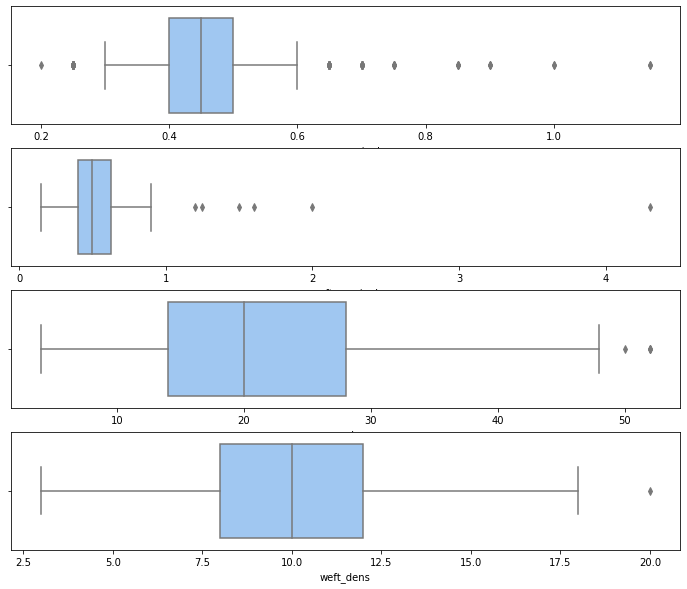

In [49]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

sns.boxplot(ax=ax[0], x=textiles.warp_nominal)
sns.boxplot(ax=ax[1], x=textiles.weft_nominal)
sns.boxplot(ax=ax[2], x=textiles.warp_dens)
sns.boxplot(ax=ax[3], x=textiles.weft_dens)

plt.savefig('../images/boxplots.png')

Как можно заметить, и по тощине нитей основы, и по толщине нитей утка имеется некторое количество выбросов  
То же справделиво и для плотностей тканей, хотя, в данном случае количество выбросов представляется меньшим

## Получение "выбросов" в данных

Под "выбросами" подразумеваются экземпляры данных с аномально отклоняющимися от средних величин выборки значениями тех  
или иных параметров

In [9]:
def _remove_outliers(df, column):
    """ """
    q1 = df[column].quantile(0.20)
    q3 = df[column].quantile(0.80)
    iq_range = q3 - q1  # Interquartile range;
    low_fence  = q1 - 1.5 * iq_range
    high_fence = q3 + 1.5 * iq_range
    df_out = df.loc[(df[column] > low_fence) & (df[column] < high_fence)]
    return df_out

def remove_outliers(df, column):
    """ """
    if type(column) is list:
        for column_name in column:
            df = _remove_outliers(df, column_name)
        return df
    elif type(column) is str:
        return _remove_outliers(df, column)

In [10]:
# получение выбросов по толщинам нитей;
cleared_thick_warp = remove_outliers(textiles, 'warp_mean')
cleared_thick_weft = remove_outliers(textiles, 'weft_mean')

In [11]:
# получение выбросов по плотностям тканей;
cleared_dens_warp = remove_outliers(textiles, 'warp_dens')
cleared_dens_weft = remove_outliers(textiles, 'weft_dens')

In [12]:
cleared_thick = remove_outliers(textiles, ['warp_mean', 'weft_mean'])
cleared_dens = remove_outliers(textiles, ['warp_dens', 'weft_dens'])

In [13]:
outliers_thick = pd.concat([textiles, cleared_thick]).drop_duplicates(keep=False)
outliers_dens = pd.concat([textiles, cleared_dens]).drop_duplicates(keep=False)

In [14]:
outliers = pd.concat([outliers_thick, outliers_dens]).drop_duplicates(keep=False)
cleared = pd.concat([textiles, outliers]).drop_duplicates(keep=False)

In [15]:
cleared_coef = remove_outliers(textiles, 'dens_coef')
outliers_coef = pd.concat([textiles, cleared_coef]).drop_duplicates(keep=False)
print(len(outliers_coef))

3


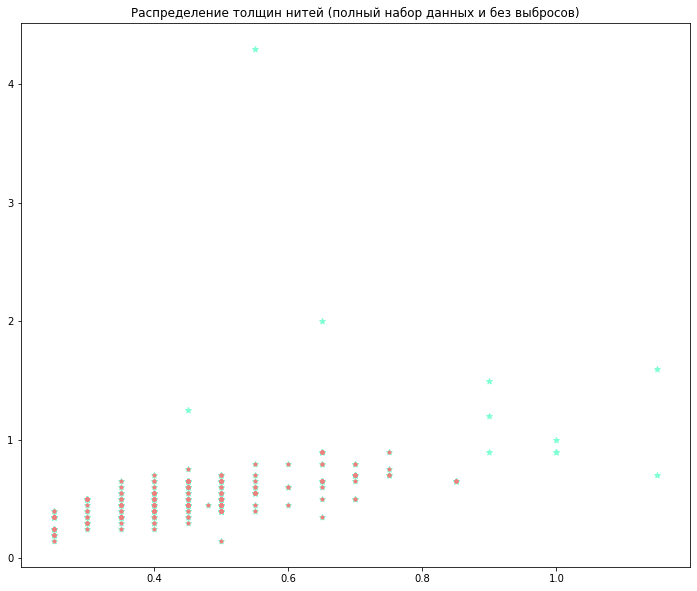

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(textiles.warp_mean.tolist(), textiles.weft_mean.tolist(), marker='*', color='aquamarine')
ax.scatter(cleared_thick.warp_mean.tolist(), cleared_thick.weft_mean.tolist(), marker='.', color='lightcoral')
ax.set_title('Распределение толщин нитей (полный набор данных и без выбросов)')

plt.show()

## Графики распределения толщин нитей и плотностей тканей после удаления выбросов 

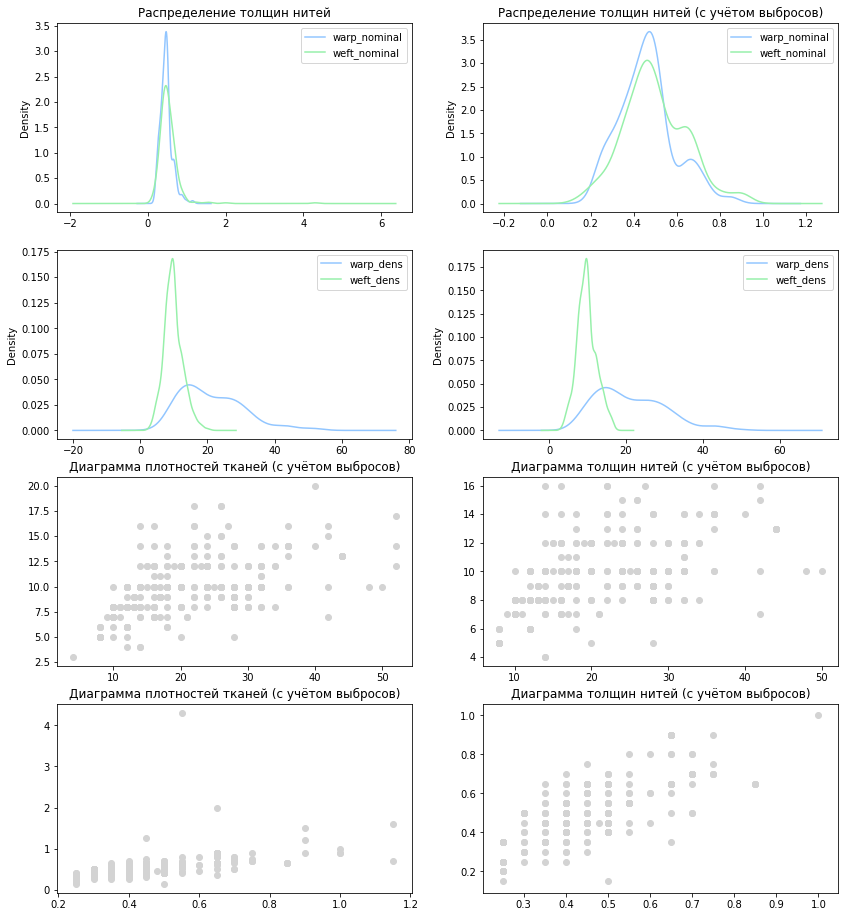

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(14, 16))

ax[0][0].set_title('Распределение толщин нитей')
ax[0][1].set_title('Распределение толщин нитей (с учётом выбросов)')
ax[1][0].set_title('')
ax[1][1].set_title('')
ax[2][0].set_title('Диаграмма плотностей тканей (с учётом выбросов)')
ax[2][1].set_title('Диаграмма толщин нитей (с учётом выбросов)')
ax[3][0].set_title('Диаграмма плотностей тканей (с учётом выбросов)')
ax[3][1].set_title('Диаграмма толщин нитей (с учётом выбросов)')

textiles.warp_nominal.plot.kde(ax=ax[0][0])
textiles.weft_nominal.plot.kde(ax=ax[0][0])

cleared.warp_nominal.plot.kde(ax=ax[0][1])
cleared.weft_nominal.plot.kde(ax=ax[0][1])

textiles.warp_dens.plot.kde(ax=ax[1][0])
textiles.weft_dens.plot.kde(ax=ax[1][0])

cleared.warp_dens.plot.kde(ax=ax[1][1])
cleared.weft_dens.plot.kde(ax=ax[1][1])

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()

ax[2][0].scatter(textiles.warp_dens.tolist(), textiles.weft_dens.tolist(), color='lightgray')
ax[2][1].scatter(cleared.warp_dens.tolist(), cleared.weft_dens.tolist(), color='lightgray')
ax[3][0].scatter(textiles.warp_mean.tolist(), textiles.weft_mean.tolist(), color='lightgray')
ax[3][1].scatter(cleared.warp_mean.tolist(), cleared.weft_mean.tolist(), color='lightgray')

plt.show()

In [18]:
# saving dataframes to csv format;
outliers_thick.to_csv('../output/outliers/thick.csv')
outliers_dens.to_csv('../output/outliers/dens.csv')
cleared.to_csv('../output/cleared.csv')

# saving dataframes to excel format;
outliers_thick.to_excel('../output/outliers/outliers_thick.xls')
outliers_dens.to_excel('../output/outliers/outliers_dens.xls')
cleared.to_excel('../output/cleared.xls')